Ushbu amaliy mashg'ulotda *Jupyter Notebook* dasturi orqali Piton dasturlash tilida Neyron tarmoq muammosini o'rganamiz.

Quyidagi Piton bibliotekalarini yuklab olamiz:
- *numpy* - Pitonda massivlar bilan ishlash uchun
- *matplotlib* - Pitonda vizualizatsiya, diagrammalar bilan ishlash
- *h5py* - HDF5 binar formatdagi fayllar bilan ishlovchi biblioteka. Ko'proq ma'lumot uchun: https://docs.h5py.org/en/stable/
- *sklearn* - Pitonda mashinaviy o'qitish algoritmlari bilan ishlash uchun *Scikit-learn* bibliotekasi. Biz ushbu bibliotekadan modelning aniqliligini o'lchashda foydalanamiz.
Ushbu mashg'ulotdagi kod https://zhenye-na.github.io/2018/09/09/build-neural-network-with-mnist-from-scratch.html ssilkadagi yechimga asoslangan.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import h5py
from sklearn import metrics

Biz http://yann.lecun.com/exdb/mnist/ saytda keltirilgan MNIST ma'lumotlar to'plamidan foydalanamiz. MNIST ma'lumotlar to'plami bilan ishlashni qulaylashtirish uchun *python-mnist* bibliotekasini o'rnatamiz.
- pip install python-mnist

Hisoblarda qulayroq bo'lishi uchun, ushbu ma'lumotlar to'plamining *h5py* formatdagi ko'rinishidan foydalanamiz. Ma'lumotlar to'plamini quyidagi ssilkadan yuklab olib, ushbu *.ipynb* fayl joylashgan katalogga yuklash kerak bo'ladi. 
https://github.com/Zhenye-Na/cs598/blob/master/assignments/mp1/MNISTdata.hdf5

*h5py* bibliotekasi yordamida ma'lumotlar to'plamini yuklaymiz:

In [25]:
# load MNIST data
MNIST_data = h5py.File("./MNISTdata.hdf5", 'r')

Ma'lumotlar to'plamini *numpy* formatidagi massivga yuklaymiz, bunda kerakli formatni ko'rsatamiz, ya'ni kiruvchi to'plam uchun *float32* va nishonlar to'plami uchun *int32*. 

In [26]:
x_train = np.float32(MNIST_data['x_train'][:])
y_train = np.int32(np.array(MNIST_data['y_train'][:, 0])).reshape(-1, 1)
x_test  = np.float32(MNIST_data['x_test'][:])
y_test  = np.int32(np.array(MNIST_data['y_test'][:, 0])).reshape(-1, 1)
MNIST_data.close()

In [27]:
x_train.shape

(60000, 784)

Ma'lumotlar to'plami to'g'ri yuklanganini tekshirish uchun, matplotlib kutubxonasi orqali ma'lumotlar to'plamining biron elementini chizib ko'ramiz.

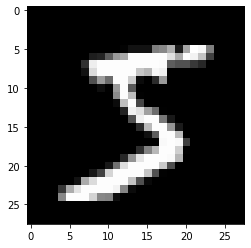

In [28]:
plt.imshow(x_train[0,:].reshape(28,28), cmap='gray')

Ko'rib turganimizdek, 5 raqamini tasvirlovchi rasm chizildi, va bu shundan dalolat beradiki, ma'lumotlar to'plami to'g'ri yuklangan.

Ma'lumotlar to'plami bilan kengroq tanishib chiqaylik. Avvalo, to'plamlar qanday hajmda ekanini aniqlaylik:

In [29]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 784)
(60000, 1)
(10000, 784)
(10000, 1)


Biz arxitekturasi quyida keltirilgan neyron tarmoqni qo'llaymiz:

![alt text](images/nn_pr_neural_net_arch_0.png "Title")

Neyron tarmoqning ushbu arxitekturasida, 3 ta qatlam ishtirok etmoqda:
- Kirish qatlami o'lchami: 784
- Yashirin qatlam, yoki 2-qatlam 64 ta neyrondan iborat
- Chiquvchi qatlam, yoki 3-qatlam 10ta neyrondan iborat

Ushbu arxitekturaga moslash uchun, kiruvchi to'plamning shaklini o'zgartiraylik, ya'ni transpozitsiyalaylik:

In [30]:
x_train = x_train.T
x_test = x_test.T

Kiruvchi to'plam aslida har biri *28x28* (shunda *28x28* matritsani bir o'lchamli vektorga aylantirsak, o'lchami 784 bo'lgan vektor hosil bo'ladi) hajmli tasvirdagi piksellarni ifoda etuvchi $60000$ mashq hamda $10000$ test elementlaridan iborat. Kiruvchi matrisalar elementlari $[0,1]$ oraliqda joylashgani sababli kirish sayqallanishi jarayoniga hojat yo'q.

***Neyron tarmoqqa kirishda qulay bo'lishi uchun, mashq to'plaminining shaklini *784x60000* va test to'plamini *784x10000* ko'rinishga keltirib oldik.

Nishonlar to'g'risida so'z yuritsak, ular qanday ko'rinishda ekanini ko'rish uchun ularning ba'zi elementlarini chop etaylik.

In [31]:
y_train[:, :10]

array([[5],
       [0],
       [4],
       ...,
       [5],
       [6],
       [8]], dtype=int32)

Ko'rib turganimizdek, nishon to'plami o'zida $[0,9]$ oraliqda joylashgan butun sonlarni jam etadi. Nishon to'plamini qiymati $0$ va $1$dan iborat bo'lgan one-hot-vektor to'plamiga aylantiramiz. Buning uchun bir qancha yordamchi o'zgaruvchilarni aniqlab olaylik, xususan:
- digits - one-hot-vektor elementining uzunligi
- m_train - mashq to'plami uzunligi
- m_test - test to'plami uzunligi

In [32]:
digits = 10
m_train = y_train.shape[0] #60000
m_test = y_test.shape[0] #60000

In [33]:
print('m_train: %d, m_test: %d'%(m_train, m_test))

m_train: 60000, m_test: 10000


Endi mashq hamda test to'plamini one-hot-vector massivga aylantiramiz, bunda *numpy* bibliotekasining *eye* funksiyasidan foydalanamiz.

In [34]:
y_train_old = y_train
y_test_old = y_test
y_train = np.eye(digits)[y_train.astype('int32')]
y_train = y_train.T.reshape(digits, m_train)

y_test = np.eye(digits)[y_test.astype('int32')]
y_test = y_test.T.reshape(digits, m_test)

Nishonlarni one-hot-vector massivlarga aylanganligini tekshirib ko'raylik:

In [35]:
print(y_train_old[2,:])
y_train[:,2]

[4]


array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

Yuqorida chop etilgandan ko'rinib turibdiki, qiymati 4 bo'lgan nishon - uzunligi 10ga teng bo'lgan vektorga aylantirildi, va ushbu vektorning 4-tartib raqamli elementi (hisob 0 dan boshlanganda) 1 ga teng,

In [36]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(784, 60000)
(10, 60000)
(784, 10000)
(10, 10000)


Neyron tarmoqning quyidagi giperparametrlarini aniqlab olaylik:
 - lr (learning rate) - o'rganish darajasi
 - epochs - neyron tarmoqning takrorlanish davri
 - n_x - kirish qatlami uzunligi
 - n_h - yashirin, ya' 2-qatlamdagi neyronlar soni
 - batch_size - batch uzunligi
 - batches - batchlar soni

In [37]:
lr = 0.5 #learning rate
epochs = 50 #number of epochs to train
n_x = 784 #number of inputs
n_h = 64 #number of hidden units
batch_size = 64 #input batch size    
batches = m_train // batch_size # number of batches

Neyron tarmoqning koefisientlarini *numpy* bibliotekasidan foydalangan holda inisializatsiya qilaylik:
- A1 - 2-qatlamning asosiy koefisientlari massivi
- b1 - 2-qatlamning bias koefisientlari massivi
- A2 - 3-qatlamning asosiy koefisientlari massivi
- b2 - 3-qatlamning bias koefisientlari massivi

Bias koefisientlarning ilk qiymati sifatida $0$ tanlangan bo'lsa, asosiy koefisientlarga esa Xavier inisializatsiya yo'li yordamida ilk qiymatlar berilmoqda.

In [38]:
# initialization
params = {"A1": np.random.randn(n_h, n_x) * np.sqrt(1. / n_x),
          "b1": np.zeros((n_h, 1)),
          "A2": np.random.randn(digits, n_h)* np.sqrt(1. / n_h),
          "b2": np.zeros((digits, 1))
         }

Shu koefisientlarning qiymat funksiyasiga ta'sirini ifodalovchi qiymatlarni o'zida saqlovchi o'zgaruvchilarni ham e'lon qilaylik va inisializatsiya qilaylik:
- dA1 A1 koefisientlarning qiymat funksiyasiga ta'siri
- db1 b1 koefisientlarning qiymat funksiyasiga ta'siri
- dA2 A2 koefisientlarning qiymat funksiyasiga ta'siri
- db2 b2 koefisientlarning qiymat funksiyasiga ta'siri

In [39]:
dA1 = np.zeros(params["A1"].shape)
db1 = np.zeros(params["b1"].shape)
dA2 = np.zeros(params["A2"].shape)
db2 = np.zeros(params["b2"].shape)

Koefisientlarning o'zgaruvchilar bilan ko'paytmasini amalga oshiruvchi funksiyani ifodalaylik. Ushbu funksiya quyidagi formulaga asoslangan:

$Z = a_1 \times c_1 + a_2 \times c_2 + ... + a_n \times c_n + b $

Bu formulada, $a_i$ - ma'lum qatlam koefisientlari, $c_i$ - ushbu qatlamga kiruvchi o'zgaruvchilar va $b$ - bias

In [40]:
def layer_multiplication(A, C, B):
    return np.matmul(A, C) + B

2-qatlam uchun chiquvchi funksiya, ya'ni sigmoid funksiyasini e'lon qilaylik. Ushbu funksiya quyidagi formulaga asoslangan:

$\sigma (z) = \frac{1}{1 + e^{-z}}$

In [41]:
def sigmoid(Z):
    s = 1. / (1. + np.exp(-Z))
    return s

Oxirgi qatlamning chiqish funksiyasi sifatida ishtirok etuvchi softmax funksiyasini ham Pitonda aniqlab olaylik. Uning formulasi quyidacha:

$softmax(z)_i = \frac{e^{z_i}}{\sum_{j=1}^{K}e^{z_j}}$ , $i = [1, ..., K] $ hamda $ z = [z_1, ..., z_K]$ oraliqlarida

Bunda bizda $K=10$, ya'ni 10 ta klass mavjud ($0, 1, ... 9$)

In [42]:
def softmax(Z):
    return np.exp(Z) / np.sum(np.exp(Z), axis=0)

Qiymat funksiyasini ifodalaylik, bunda biz multi-klass muammosi uchun qiymat funksiyasini quyidagi formulaga asosan ifodalaymiz:

$J(a) = - \frac{1}{m} \sum_{i=1}^m{y_k^{(i)} log(h_a(x^{(i)}))}$ 

In [43]:
def compute_loss(Y, Y_hat):
    """
    compute loss function
    """
    L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
    m = Y.shape[1]
    L = -(1./m) * L_sum

    return L

Oldinga siljish algoritmini aniqlaylik. Bunda biz quyidagi ketma ketlikda algoritmni amalga oshirib oxirgi natijani olamiz:
1. 2 - qatlam uchun koefisientlar va kiruvchi qatlam ko'paytmasi yig'indisini hisoblab olamiz va $cache["Z1"]$ piton lug'atiga saqlaymiz
2. 2 - qatlamning chiqish funksiyasini (sigmoid) hisoblaymiz, bunda natijani $cache["C1"]$ lug'atda saqlaymiz
3. 3 - qatlam uchun koefisientlar va kiruvchi qatlam ko'paytmasi yig'indisini hisoblab olamiz va $cache["Z2"]$ piton lug'atiga saqlaymiz
4. 3 - qatlamning chiqish funksiyasini (softmax) hisoblaymiz, bunda natijani $cache["C1"]$ lug'atda saqlaymiz

In [44]:
def feed_forward(X, params):
    cache = {}

    # Z1 = A1.dot(x) + b1
    cache["Z1"] = layer_multiplication(params["A1"], X, params["b1"])

    # C1 = sigmoid(Z1)
    cache["C1"] = sigmoid(cache["Z1"])

    # Z2 = A2.dot(A1) + b2
    cache["Z2"] = layer_multiplication(params["A2"], cache["C1"], params["b2"])

    # C2 = softmax(Z2)
    cache["C2"] = softmax(cache["Z2"])

    return cache

Ortga siljish algoritmini amalga oshiramiz. Ortga siljish algoritmini oxirgi qatlamdan boshlaymiz va qatlamlar bo'ylab teskari harakatlanamiz. Bunda har bir qatlamdagi koefisientlarning qiymat funksiyasiga ta'sirini aniqlaymiz va kerakli o'zgaruvchilarga saqlaymiz.

In [45]:
def back_propagate(X, Y, params, cache, m_batch):
    # error at last layer
    delta_2 = cache["C2"] - Y

    # gradients at last layer (Py2 need 1. to transform to float)
    dA2 = (1. / m_batch) * np.matmul(delta_2, cache["C1"].T)
    db2 = (1. / m_batch) * np.sum(delta_2, axis=1, keepdims=True)

    # back propgate through first layer
    delta_1 = np.matmul(params["A2"].T, delta_2) * (sigmoid(cache["Z1"]) * (1 - sigmoid(cache["Z1"])))

    # gradients at first layer (Py2 need 1. to transform to float)
    dA1 = (1. / m_batch) * np.matmul(delta_1, X.T)
    db1 = (1. / m_batch) * np.sum(delta_1, axis=1, keepdims=True)

    grads = {"dA1": dA1, "db1": db1, "dA2": dA2, "db2": db2}

    return grads

Neyron tarmoqni amalga oshirish uchun barcha funksiyalarni aniqlab bo'ldik, endi bevosita neyron tarmoqdagi hisob kitoblarni boshlasak bo'ladi. E'tibor bering, bizda ikki sikl ishtirok etmoqda, ya'ni birinchi sikl qadamlarni ifoda etsa, ikkinchi sikl esa mashq to'plamining mayda bo'laklarga bo'lingan guruhlarni o'z ichiga oluvchi batchesni ifodalaydi. Har bir qadamda test va mashq to'plamlaridagi xatoliklar hisoblab boriladi va mos ravishda $test\_costs$ va $train\_costs$ massivlarida saqlanadi.

In [46]:
test_costs = []
train_costs = []
# training
for i in range(epochs):

    # shuffle training set
    permutation = np.random.permutation(x_train.shape[1])
    X_train_shuffled = x_train[:, permutation]
    Y_train_shuffled = y_train[:, permutation]

    for j in range(batches):

        # get mini-batch
        begin = j * batch_size
        end = min(begin + batch_size, x_train.shape[1] - 1)
        X = X_train_shuffled[:, begin:end]
        Y = Y_train_shuffled[:, begin:end]
        m_batch = end - begin

        # forward and backward
        cache = feed_forward(X, params)
        grads = back_propagate(X, Y, params, cache, m_batch)
        
        dA1 = grads["dA1"]
        db1 = grads["db1"]
        dA2 = grads["dA2"]
        db2 = grads["db2"]
        
        # gradient descent
        params["A1"] = params["A1"] - lr * dA1
        params["b1"] = params["b1"] - lr * db1
        params["A2"] = params["A2"] - lr * dA2
        params["b2"] = params["b2"] - lr * db2

    # forward pass on training set
    cache = feed_forward(x_train, params)
    train_loss = compute_loss(y_train, cache["C2"])
    train_costs.append(train_loss)

    # forward pass on test set
    cache = feed_forward(x_test, params)
    test_loss = compute_loss(y_test, cache["C2"])
    test_costs.append(test_loss)
    if i % 10 == 0 or i == epochs -1:
        print("Epoch {}: training loss = {}, test loss = {}".format(
            i + 1, train_loss, test_loss))

Epoch 1: training loss = 0.25363514063736736, test loss = 0.25081073811714294
Epoch 11: training loss = 0.05886456975993621, test loss = 0.08787725606448088
Epoch 21: training loss = 0.03170710019303508, test loss = 0.07914492305547167
Epoch 31: training loss = 0.018595611484698654, test loss = 0.07900983113358759
Epoch 41: training loss = 0.012576158887516923, test loss = 0.08000798691994716
Epoch 50: training loss = 0.009289235194238864, test loss = 0.08380877467053


Gradient tushishda qiymat funksiyasining qay darajada o'zgarganini vizual ko'rish uchun, grafik *plot_cost* funksiyasini yarataylik, ushbu funksiya *matplotlib* bibliotekasidan foydalanib graf chizadi.

In [244]:
def plot_cost(train_costs,test_costs, epochs):
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.plot(epochs, train_costs, 'm', linewidth = "1", color='r', label='mashqdagi xatolik')
    plt.plot(epochs, test_costs, 'm', linewidth = "1", color='g', label='testdagi xatolik')
    plt.legend(loc="upper right")
    plt.show()

*plot_cost* funksiyasi parametr sifatida 3 ta massiv o'zgaruvchisini qabul qiladi va bular:
-  mashq to'plami uchun qiymat funksiyasining natijasi ifodalangan massiv, *train_costs* o'zgaruvchisi
-  test to'plami uchun qiymat funksiyasining natijasi ifodalangan massiv, *test_costs* o'zgaruvchisi
- qadamlarni ifoda etuvchi massiv, *epochs* o'zgaruvchisi

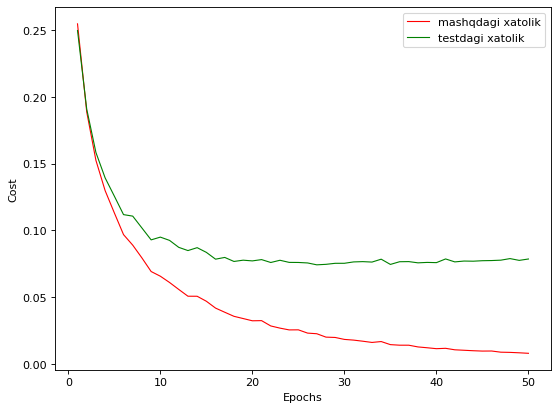

In [246]:
n_epochs = np.arange(1, epochs + 1)
figure(figsize=(8, 6), dpi=80)
plot_cost(train_costs, test_costs, n_epochs)

Yuqoridagi diagrammadan ko'rib turibmizku, davrning har qadamida mashq va test to'plamlarda qiymat funksiyasi tushib boryapti. Shuni ta'kidlab o'tish kerakki, davrning taxminan 20-qadamidan keyin test to'plamida qiymat funksiyasi tushmayapti, va hatto ko'rishimiz mumkinki, biroz bo'lsada ko'tarilmoqda ham. Bu shundan dalolat beryaptiki, bizning neyron tarmog'imiz 20-qadamdayoq o'zining optimal parametrlariga ega bo'lgan, va undan keyingi qadamlar asosan neyron tarmoq mashq to'plamida yaxshi natija berishi, va aksincha test to'plamida xatoliklar ko'payishidan dalolat beradi.

Neyron tarmoqni endi test to'plamida sinab ko'raylik:

In [248]:
test_predictions = feed_forward(x_test, params)["C2"]
test_predictions

array([[9.37769683e-08, 2.90340676e-07, 1.89968251e-09, ...,
        1.11845960e-10, 8.69757880e-12, 4.82012891e-07],
       [1.89298225e-08, 1.07912738e-06, 9.99763163e-01, ...,
        5.85822380e-09, 2.10657068e-08, 1.76601778e-08],
       [3.36284387e-07, 9.99994754e-01, 4.76733054e-05, ...,
        2.44859178e-09, 3.49040052e-11, 5.03604315e-07],
       ...,
       [9.99631269e-01, 1.05390665e-11, 8.87547191e-06, ...,
        6.04776461e-06, 4.23420533e-11, 1.29963589e-12],
       [8.30622225e-08, 1.19521048e-06, 1.74109287e-04, ...,
        1.00960292e-06, 3.95766112e-05, 3.79695532e-08],
       [6.59780753e-05, 5.20122160e-13, 2.98024899e-08, ...,
        7.26598907e-07, 5.17062984e-11, 5.48595430e-08]])

Neyron tarmoq test to'plamiga tatbiq qilindi va so'ngi chiqish funksiyasining natijasi one-hot vektor bo'lib, ularni $[0,9]$ oraqlidagi sonlarga aylantiraylik:

In [254]:
test_predictions_label = np.argmax(test_predictions, axis=0)

In [255]:
test_predictions_label

array([7, 2, 1, ..., 4, 5, 6])

In [251]:
 np.argmax(test_predictions, axis=0)

array([7, 2, 1, ..., 4, 5, 6])

In [252]:
y_test_old

array([[7],
       [2],
       [1],
       ...,
       [4],
       [5],
       [6]], dtype=int32)

In [263]:
y_test_old_ = np.ravel(y_test_old)

In [264]:
y_test_old_

array([7, 2, 1, ..., 4, 5, 6], dtype=int32)

# Model aniqliligi (Model accuracy)

Biz yaratgan neyron tarmoq klassifikatsiyalash muammosini yechgani uchun, ushbu modelning aniqliligini o'lchashda *Accuracy* va *F1Score* o'lchovlaridan foydalanishimiz mumkin. Logistik regressiya algoritmining amalish mashg'ulotida ushbu o'lchovlarning binar-klassifikatsiyaga (ya'ni klasslar soni 2ta) tatbiqini ko'rib o'tgan edik. Bizning hozirgi mashg'ulotimiz esa ko'p-klassli muammoga bag'ishlangan, ya'ni klasslar soni 10ta (0 dan 9gacha butun sonlar). Ko'p-klassli modelga *Accuracy* va *F1 Score* o'lchovlarini tatbiq etishda chalkashlik matritsasini aniqlashimiz kerak. Ushbu matritsani aniqlaydigan funksiya yarataylik.

In [267]:
#from this answer: https://stackoverflow.com/a/53387268/4361020
def confusion_matrix(actual, predicted):
    classes       = np.unique(np.concatenate((actual,predicted)))
    confusion_mtx = np.empty((len(classes),len(classes)),dtype=np.int)
    for i,a in enumerate(classes):
        for j,p in enumerate(classes):
            confusion_mtx[i,j] = np.where((actual==a)*(predicted==p))[0].shape[0]
    return confusion_mtx

Ushbu funksiyani ishga tushiramiz va chalkashlik matritsasini olamiz.

In [265]:
cf = confusion_matrix(y_test_old_, test_predictions_label)

Ushbu chalkashlik matritsasini chop etaylik:

In [293]:
cf

array([[ 968,    0,    2,    0,    0,    1,    5,    1,    2,    1],
       [   0, 1126,    1,    1,    0,    1,    2,    1,    3,    0],
       [   4,    2, 1001,    5,    3,    1,    3,    9,    4,    0],
       [   0,    0,    4,  984,    0,    6,    0,    4,    5,    7],
       [   2,    0,    1,    1,  955,    1,    4,    2,    1,   15],
       [   2,    1,    0,   11,    0,  863,    6,    1,    5,    3],
       [   4,    2,    1,    1,    4,    6,  939,    0,    1,    0],
       [   0,    3,    7,    4,    1,    0,    0, 1002,    1,   10],
       [   4,    1,    3,    4,    7,    2,    3,    4,  945,    1],
       [   2,    3,    0,    5,    8,    3,    0,    8,    0,  980]])

In [306]:
for i in range(10):
    #printing labels
    if i ==0:
        print('\t', end='')
        for j in range(10):
            print('b:', j, end='\t')
        print('\n')
    
    print('t:', i, end='\t')
    for j in range(10):
        print(cf[i][j], end='\t')
    print('\n')

	b: 0	b: 1	b: 2	b: 3	b: 4	b: 5	b: 6	b: 7	b: 8	b: 9	

t: 0	968	0	2	0	0	1	5	1	2	1	

t: 1	0	1126	1	1	0	1	2	1	3	0	

t: 2	4	2	1001	5	3	1	3	9	4	0	

t: 3	0	0	4	984	0	6	0	4	5	7	

t: 4	2	0	1	1	955	1	4	2	1	15	

t: 5	2	1	0	11	0	863	6	1	5	3	

t: 6	4	2	1	1	4	6	939	0	1	0	

t: 7	0	3	7	4	1	0	0	1002	1	10	

t: 8	4	1	3	4	7	2	3	4	945	1	

t: 9	2	3	0	5	8	3	0	8	0	980	



Yuqoridagi matritsani tavfsiflasak, diagonal ravishda o'qlar qiymati bir xil bo'lgan (masalan, $t:0$-$b:0$ yacheyka) yacheykalar - model tomonidan to'g'ri topilgan klasslarning klass qiymati bo'yicha kesishmasini anglatadi. Gorizontal o'q esa test to'plamidagi haqiqiy klasslarning model tomonidan bashorat qilingan klasslar soni kesishmasidir. Ya'ni, $t:0$ qatorni olaylik. Ushbu qator test to'plamdagi haqiqiy qiymati $0$ bo'lgan klassning model tomonidan qanday bashorat qilinganini anglatadi. Xususan, $t:0$-$b:0$ yacheykaning qiymati $968$ - ya'ni 968 ta $0$ klass model tomonidan to'g'ri topilgan. $t:0$-$b:5$ yacheykaning qiymati esa $1$, bu degani test to'plamdagi haqiqiy qiymati $0$ bo'lgan klass model tomonidan bir marta $5$ deya noto'g'ri topilgan. 

Biz ushbu chalkashlik matritsasidan foydalanib, har bir klass uchun F1-hisobni aniqlashimiz mumkin, va quyidagi funksiyani yarataylik:

In [291]:
def calculate_f1_score_accuracy(cf, n):
    actual_sum = np.sum(cf, axis=1)
    predicted_sum = np.sum(cf, axis=0)
    print('raqam \t precision \t recall \t f1-score haqiqiy_klasslar soni')
    total_correct_sum = 0
    for i in range(10):
        correct_sum = cf[i][i]
        total_correct_sum += correct_sum
        precision = correct_sum / predicted_sum[i]
        recall = correct_sum / actual_sum[i]
        f1_score = 2 * precision * recall / (precision + recall)
        print(i, '\t', round(precision, 5), '\t', round(recall, 5),'\t', round(f1_score, 5),'\t', actual_sum[i])
    total_accuracy = total_correct_sum / n
    print('Accuracy: ', total_accuracy)

Ushbu funksiyadan foydalanib, modelning aniqliligini o'lchaylik:

In [307]:
calculate_f1_score_accuracy(cf, m_test)

raqam 	 precision 	 recall 	 f1-score haqiqiy_klasslar soni
0 	 0.98174 	 0.98776 	 0.98474 	 980
1 	 0.98946 	 0.99207 	 0.99076 	 1135
2 	 0.98137 	 0.96996 	 0.97563 	 1032
3 	 0.9685 	 0.97426 	 0.97137 	 1010
4 	 0.97648 	 0.97251 	 0.97449 	 982
5 	 0.97624 	 0.96749 	 0.97185 	 892
6 	 0.97609 	 0.98017 	 0.97812 	 958
7 	 0.97093 	 0.97471 	 0.97282 	 1028
8 	 0.97725 	 0.97023 	 0.97372 	 974
9 	 0.96362 	 0.97126 	 0.96742 	 1009
Accuracy:  0.9763


Yuqoridagi jadval har bir klass uchun *precision*, *recall*, *f1-hisob*, test to'plamidagi haqiqiy klasslar sonini va modelning *accuracy* o'lchovi uchun qiymatlarni chop etadi. Ko'rib turibmizki, har bir klass uchun f1-hisob ancha yuqori. Hamda umumiy aniqlik, ya'ni accuracy juda yuqori, bu degani test to'plamdagi 97% element to'g'ri topilgan.

In [270]:
print(metrics.confusion_matrix(y_test_old_, test_predictions_label))

[[ 968    0    2    0    0    1    5    1    2    1]
 [   0 1126    1    1    0    1    2    1    3    0]
 [   4    2 1001    5    3    1    3    9    4    0]
 [   0    0    4  984    0    6    0    4    5    7]
 [   2    0    1    1  955    1    4    2    1   15]
 [   2    1    0   11    0  863    6    1    5    3]
 [   4    2    1    1    4    6  939    0    1    0]
 [   0    3    7    4    1    0    0 1002    1   10]
 [   4    1    3    4    7    2    3    4  945    1]
 [   2    3    0    5    8    3    0    8    0  980]]


In [272]:
print(metrics.classification_report(y_test_old_, test_predictions_label, digits=10))

              precision    recall  f1-score   support

           0  0.9817444219 0.9877551020 0.9847405900       980
           1  0.9894551845 0.9920704846 0.9907611087      1135
           2  0.9813725490 0.9699612403 0.9756335283      1032
           3  0.9685039370 0.9742574257 0.9713721619      1010
           4  0.9764826176 0.9725050916 0.9744897959       982
           5  0.9762443439 0.9674887892 0.9718468468       892
           6  0.9760914761 0.9801670146 0.9781250000       958
           7  0.9709302326 0.9747081712 0.9728155340      1028
           8  0.9772492244 0.9702258727 0.9737248841       974
           9  0.9636184857 0.9712586720 0.9674234946      1009

    accuracy                      0.9763000000     10000
   macro avg  0.9761692473 0.9760397864 0.9760932944     10000
weighted avg  0.9763166210 0.9763000000 0.9762972150     10000

